### Model to differenciate between muons, electrons and noise NOISY

Labels: 0 noise, 1 electron, 2 muon
* [Creating training and validation generators](#Creating-training-and-validation-generators)
* [Model 1: 82 neurons, callbacks, bigger lr](#Model-1:-82-neurons,-callbacks,-bigger-lr)
* [Model 2: 202 + 82 neurons, bigger lr](#Model-2:-202-+-82-neurons,-bigger-lr)
* [Model 3: 82 neurons, dropouts, bigger lr](#Model-3:-82-neurons,-dropouts,-bigger-lr)
* [Model 4: 300+92 neurons, bigger lr](#Model-4:-300+92-neurons,-bigger-lr)
* [Model 5: 82 neurons, bigger lr, dropouts](#Model-5:-82-neurons,-bigger-lr,-dropouts)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize= 16)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize= 16)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18)
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
    plt.grid(b=False)
    plt.xlim(-0.5, 2.5)
    plt.ylim(2.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

In [32]:
import keras
from keras import layers, models, optimizers
from keras import callbacks

In [3]:
window_y, window_x = 242,192 #shape of each image

In [4]:
import glob
import os, shutil
from sklearn.metrics import classification_report

### Creating training and validation generators
We need to create a numpy array (X) with the path to each npz file. Each npz contains 64 npy (batch_size), so basically, one npz is one batch. 
* For the training batchs:

In [5]:
path_tr = 'eVSmuVSn_N2tr/'
files_tr = os.listdir(path_tr)

X = np.empty(shape=(len(files_tr),), dtype=object)

for index, file in enumerate(files_tr):     
    X[index] = os.path.join(path_tr, files_tr[index]) 

In [6]:
X.shape #we have 157 batchs (npz files) for the training

(157,)

In [7]:
def data_generator2(inputs, shuffle=True):
     while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)

        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
 
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label

            yield batch_X, batch_y

In [8]:
train_gen =  data_generator2(inputs=X) #training data generator

In [9]:
type(train_gen)

generator

* Similary for the validation data:

In [10]:
path_v = 'eVSmuVSn_N2val/'
files_v = os.listdir(path_v)

#X is a numpy array of the baths to the npz files, where each one contains a batch of npy
X = np.empty(shape=(len(files_v),), dtype=object)

for index, file in enumerate(files_v):     
    X[index] = os.path.join(path_v, files_v[index]) 

In [11]:
X.shape #this is how many batches we have of validation data

(53,)

In [12]:
val_gen = data_generator2(inputs=X)

### Model 1: 82 neurons, callbacks, bigger lr

In [36]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dense(units= 82, activation='relu'))
model_v1.add(layers.Dense(units= 3, activation='softmax'))
model_v1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 20, 128)      

In [37]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [38]:
my_callbacks = [
    callbacks.EarlyStopping(patience=7)
]

In [39]:
historyv1 = model_v1.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53, callbacks = my_callbacks)

Epoch 1/40
157/157 [==============================] - 237s 2s/step - loss: 0.6225 - acc: 0.6969 - val_loss: 0.6059 - val_acc: 0.7603
Epoch 2/40
157/157 [==============================] - 225s 1s/step - loss: 0.4735 - acc: 0.7745 - val_loss: 0.3615 - val_acc: 0.7665
Epoch 3/40
157/157 [==============================] - 214s 1s/step - loss: 0.4389 - acc: 0.7928 - val_loss: 0.3692 - val_acc: 0.7656
Epoch 4/40
157/157 [==============================] - 214s 1s/step - loss: 0.3914 - acc: 0.8172 - val_loss: 0.2762 - val_acc: 0.8081
Epoch 5/40
157/157 [==============================] - 215s 1s/step - loss: 0.3666 - acc: 0.8416 - val_loss: 0.5468 - val_acc: 0.7471
Epoch 6/40
157/157 [==============================] - 214s 1s/step - loss: 0.3178 - acc: 0.8735 - val_loss: 0.5362 - val_acc: 0.7933
Epoch 7/40
157/157 [==============================] - 253s 2s/step - loss: 0.2983 - acc: 0.8849 - val_loss: 0.5772 - val_acc: 0.7739
Epoch 8/40
157/157 [==============================] - 239s 2s/step - 

In [40]:
model_v1.save('models/e_mu_n_Nv1.h5')

* Creating the testing data from the data generator:

In [13]:
path_t = 'eVSmuVSn_N2test/'
files_t = os.listdir(path_t)

X = np.empty(shape=(len(files_t),), dtype=object)

for index, file in enumerate(files_t):     
    X[index] = os.path.join(path_t, files_t[index]) 

In [14]:
X.shape

(53,)

In [15]:
test_gen = data_generator2(inputs=X)

Now we can evaluate model to get the accuracy in the test date:

In [41]:
loss, acc = model_v1.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 80.93%


Finally we predict, to draw the confusion matrix:

In [16]:
def test_generator(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()
        np.save('y_labels' , list_labels)

In [17]:
def gen_true_y():
    true_labels = np.load('y_labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1],3)
    true_labels = np.argmax(true_labels, axis=1)
    
    return true_labels

In [42]:
y_predicted1 = model_v1.predict_generator(test_generator(X), steps=53)

In [43]:
y_predicted1[0:10]

array([[4.98013470e-08, 8.29590619e-01, 1.70409232e-01],
       [1.20989478e-22, 3.17369252e-01, 6.82630777e-01],
       [9.98311520e-01, 1.17723655e-03, 5.11303369e-04],
       [6.08919275e-36, 2.25064845e-11, 1.00000000e+00],
       [9.86011544e-25, 9.89965796e-01, 1.00341635e-02],
       [9.98318791e-01, 1.17223791e-03, 5.08980593e-04],
       [7.37627810e-22, 1.31903458e-02, 9.86809611e-01],
       [9.98326123e-01, 1.16699724e-03, 5.06918994e-04],
       [9.98322904e-01, 1.16913894e-03, 5.07967547e-04],
       [0.00000000e+00, 1.00000000e+00, 1.62222735e-09]], dtype=float32)

In [44]:
y_predicted1 = np.argmax(y_predicted1, axis=1)

In [45]:
y_predicted1[0:10]

array([1, 2, 0, 2, 1, 0, 2, 0, 0, 1])

In [46]:
true_labels = gen_true_y()

In [47]:
true_labels[0:10]

array([1, 2, 0, 2, 1, 0, 2, 0, 0, 1])

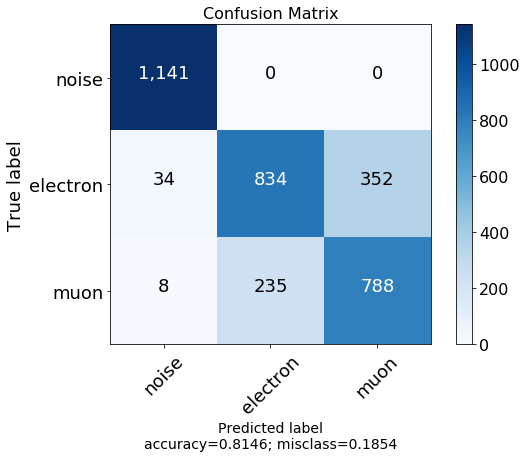

In [48]:
conf1 = confusion_matrix(true_labels, y_predicted1, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

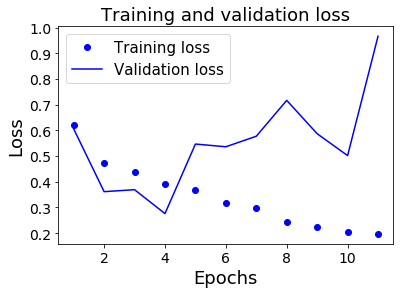

In [49]:
history_n1 = historyv1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [29]:
target_names=['noise','electron', 'muon']

In [51]:
print(classification_report(true_labels, y_predicted1, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.96      1.00      0.98      1141
    electron       0.78      0.68      0.73      1220
        muon       0.69      0.76      0.73      1031

    accuracy                           0.81      3392
   macro avg       0.81      0.82      0.81      3392
weighted avg       0.82      0.81      0.81      3392



### Model 2: 202 + 82 neurons, bigger lr

In [87]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dense(units= 202, activation='relu'))
model_v2.add(layers.Dense(units= 82, activation='relu'))
model_v2.add(layers.Dense(units= 3, activation='softmax'))
model_v2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 27, 21, 128)     

In [88]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [89]:
historyv2 = model_v2.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 212s 1s/step - loss: 0.6820 - acc: 0.6567 - val_loss: 0.5502 - val_acc: 0.7108
Epoch 2/40
157/157 [==============================] - 211s 1s/step - loss: 0.5666 - acc: 0.7265 - val_loss: 0.6397 - val_acc: 0.7538
Epoch 3/40
157/157 [==============================] - 211s 1s/step - loss: 0.5135 - acc: 0.7696 - val_loss: 0.5285 - val_acc: 0.7662
Epoch 4/40
157/157 [==============================] - 221s 1s/step - loss: 0.4697 - acc: 0.8039 - val_loss: 0.3991 - val_acc: 0.7642
Epoch 5/40
157/157 [==============================] - 227s 1s/step - loss: 0.4282 - acc: 0.8304 - val_loss: 0.6056 - val_acc: 0.7768
Epoch 6/40
157/157 [==============================] - 212s 1s/step - loss: 0.3885 - acc: 0.8508 - val_loss: 0.6184 - val_acc: 0.7527
Epoch 7/40
157/157 [==============================] - 216s 1s/step - loss: 0.3327 - acc: 0.8848 - val_loss: 0.5936 - val_acc: 0.7854
Epoch 8/40
157/157 [==============================] - 215s 1s/step - 

In [90]:
model_v2.save('models/e_mu_n_Nv2.h5')

In [91]:
loss, acc = model_v2.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 77.56%


In [92]:
y_predicted2 = model_v2.predict_generator(test_generator(X), steps=53)

y_predicted2 = np.argmax(y_predicted2, axis=1)

true_labels = gen_true_y()

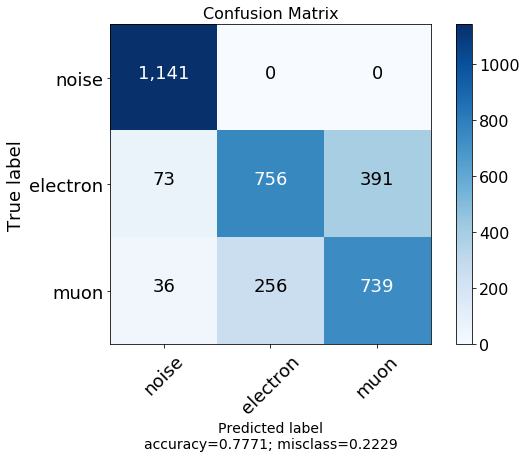

In [93]:
conf2 = confusion_matrix(true_labels, y_predicted2, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

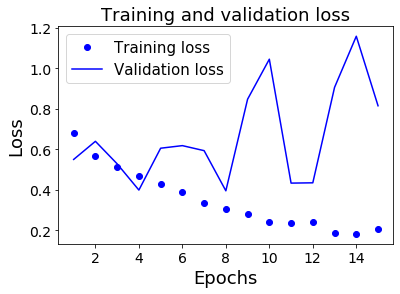

In [94]:
history_n1 = historyv2.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [95]:
print(classification_report(true_labels, y_predicted2, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.91      1.00      0.95      1141
    electron       0.75      0.62      0.68      1220
        muon       0.65      0.72      0.68      1031

    accuracy                           0.78      3392
   macro avg       0.77      0.78      0.77      3392
weighted avg       0.77      0.78      0.77      3392



### Model 3: 82 neurons, dropouts, bigger lr

In [152]:
model_v6 = models.Sequential()
model_v6.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))

model_v6.add(layers.Flatten())
model_v6.add(layers.Dropout((0.5)))
model_v6.add(layers.Dense(units= 82, activation='relu'))
model_v6.add(layers.Dropout((0.25)))
model_v6.add(layers.Dense(units= 3, activation='softmax'))
model_v6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 26, 20, 64)       

In [153]:
model_v6.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [154]:
historyv6 = model_v6.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 239s 2s/step - loss: 0.7179 - acc: 0.6528 - val_loss: 0.6189 - val_acc: 0.7217
Epoch 2/40
157/157 [==============================] - 240s 2s/step - loss: 0.5707 - acc: 0.7258 - val_loss: 0.6304 - val_acc: 0.7453
Epoch 3/40
157/157 [==============================] - 242s 2s/step - loss: 0.5564 - acc: 0.7517 - val_loss: 0.5643 - val_acc: 0.7812
Epoch 4/40
157/157 [==============================] - 236s 2s/step - loss: 0.5249 - acc: 0.7674 - val_loss: 0.5617 - val_acc: 0.8051
Epoch 5/40
157/157 [==============================] - 213s 1s/step - loss: 0.4995 - acc: 0.7851 - val_loss: 0.4543 - val_acc: 0.8022
Epoch 6/40
157/157 [==============================] - 224s 1s/step - loss: 0.4660 - acc: 0.8069 - val_loss: 0.5927 - val_acc: 0.8258
Epoch 7/40
157/157 [==============================] - 226s 1s/step - loss: 0.4570 - acc: 0.8232 - val_loss: 0.4477 - val_acc: 0.8511
Epoch 8/40
157/157 [==============================] - 224s 1s/step - 

In [155]:
model_v6.save('models/e_mu_n_Nv3.h5')

In [22]:
model_v6 = models.load_model('models/e_mu_n_Nv3.h5')

In [24]:
loss, acc = model_v6.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 87.00%


In [25]:
y_predicted6 = model_v6.predict_generator(test_generator(X), steps=53)

y_predicted6 = np.argmax(y_predicted6, axis=1)

true_labels = gen_true_y()

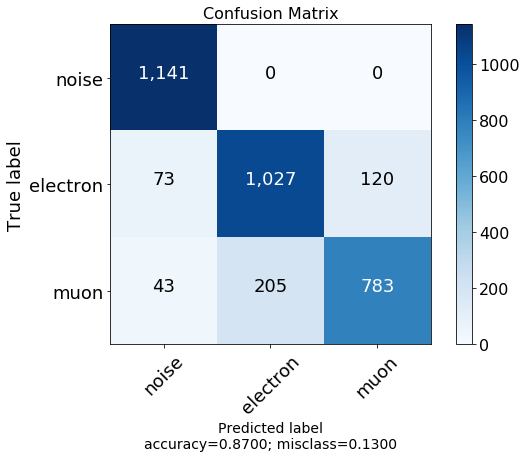

In [26]:
conf6 = confusion_matrix(true_labels, y_predicted6, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf6, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

In [27]:
history_n1 = historyv6.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#esta imagen se llama "losses.png" y está en e_VS_mu_VS_n2Noisy dentro de la carpeta de TFM

NameError: name 'historyv6' is not defined

![title](losses.png)

In [30]:
print(classification_report(true_labels, y_predicted6, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.91      1.00      0.95      1141
    electron       0.83      0.84      0.84      1220
        muon       0.87      0.76      0.81      1031

    accuracy                           0.87      3392
   macro avg       0.87      0.87      0.87      3392
weighted avg       0.87      0.87      0.87      3392



### Model 4: 300+92 neurons, bigger lr

In [78]:
model_v7 = models.Sequential()
model_v7.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))

model_v7.add(layers.Flatten())
model_v7.add(layers.Dense(units= 300, activation='relu'))
model_v7.add(layers.Dense(units= 92, activation='relu'))
model_v7.add(layers.Dense(units= 3, activation='softmax'))
model_v7.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 26, 20, 128)     

In [79]:
model_v7.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [80]:
historyv7 = model_v7.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 220s 1s/step - loss: 0.6550 - acc: 0.6650 - val_loss: 0.5525 - val_acc: 0.7544
Epoch 2/40
157/157 [==============================] - 246s 2s/step - loss: 0.5612 - acc: 0.7362 - val_loss: 0.5078 - val_acc: 0.7680
Epoch 3/40
157/157 [==============================] - 253s 2s/step - loss: 0.5173 - acc: 0.7617 - val_loss: 0.4544 - val_acc: 0.7774
Epoch 4/40
157/157 [==============================] - 233s 1s/step - loss: 0.4910 - acc: 0.7882 - val_loss: 0.4652 - val_acc: 0.7954
Epoch 5/40
157/157 [==============================] - 233s 1s/step - loss: 0.4971 - acc: 0.7965 - val_loss: 0.5911 - val_acc: 0.8287
Epoch 6/40
157/157 [==============================] - 232s 1s/step - loss: 0.4480 - acc: 0.8180 - val_loss: 0.4917 - val_acc: 0.7960
Epoch 7/40
157/157 [==============================] - 242s 2s/step - loss: 0.4384 - acc: 0.8377 - val_loss: 0.3066 - val_acc: 0.8423
Epoch 8/40
157/157 [==============================] - 232s 1s/step - 

In [81]:
model_v7.save('models/e_mu_n_Nv4.h5')

In [82]:
loss, acc = model_v7.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 83.81%


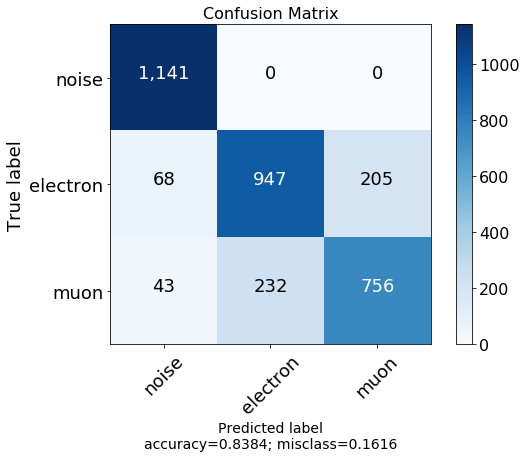

In [83]:
y_predicted7 = model_v7.predict_generator(test_generator(X), steps=53)

y_predicted7 = np.argmax(y_predicted7, axis=1)

true_labels = gen_true_y()

conf7 = confusion_matrix(true_labels, y_predicted7, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf7, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

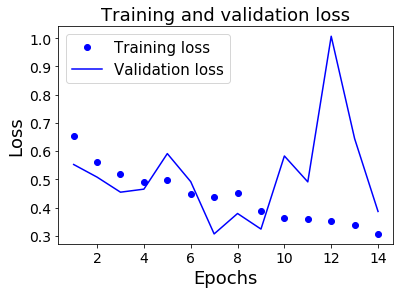

In [84]:
history_n1 = historyv7.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [85]:
print(classification_report(true_labels, y_predicted7, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.91      1.00      0.95      1141
    electron       0.80      0.78      0.79      1220
        muon       0.79      0.73      0.76      1031

    accuracy                           0.84      3392
   macro avg       0.83      0.84      0.83      3392
weighted avg       0.83      0.84      0.84      3392



### Model 5: 82 neurons, bigger lr, dropouts

In [53]:
model_v9 = models.Sequential()
model_v9.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))

model_v9.add(layers.Flatten())
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 82, activation='relu'))
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 3, activation='softmax'))
model_v9.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 20, 64)       

In [54]:
model_v9.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [55]:
historyv9 = model_v9.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 227s 1s/step - loss: 0.7431 - acc: 0.6443 - val_loss: 0.6135 - val_acc: 0.6943
Epoch 2/40
157/157 [==============================] - 214s 1s/step - loss: 0.6025 - acc: 0.7105 - val_loss: 0.4888 - val_acc: 0.7724
Epoch 3/40
157/157 [==============================] - 213s 1s/step - loss: 0.5554 - acc: 0.7485 - val_loss: 0.5079 - val_acc: 0.7739
Epoch 4/40
157/157 [==============================] - 214s 1s/step - loss: 0.5318 - acc: 0.7664 - val_loss: 0.3860 - val_acc: 0.8181
Epoch 5/40
157/157 [==============================] - 213s 1s/step - loss: 0.4914 - acc: 0.7972 - val_loss: 0.2693 - val_acc: 0.8208
Epoch 6/40
157/157 [==============================] - 214s 1s/step - loss: 0.4937 - acc: 0.8101 - val_loss: 0.4058 - val_acc: 0.8210
Epoch 7/40
157/157 [==============================] - 214s 1s/step - loss: 0.4530 - acc: 0.8251 - val_loss: 0.5629 - val_acc: 0.8479
Epoch 8/40
157/157 [==============================] - 214s 1s/step - 

In [56]:
model_v9.save('models/e_mu_n_Nv5.h5')

In [57]:
loss, acc = model_v9.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 86.53%


In [131]:
y_predicted9 = model_v9.predict_generator(test_generator(X), steps=53)

y_predicted9 = np.argmax(y_predicted9, axis=1)

true_labels = gen_true_y()

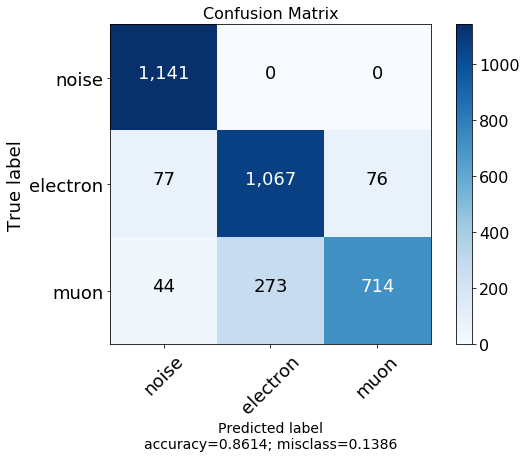

In [132]:
conf9 = confusion_matrix(true_labels, y_predicted9, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf9, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

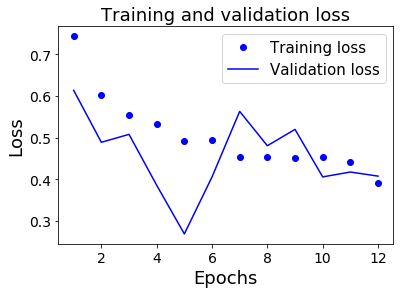

In [133]:
history_n1 = historyv9.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [61]:
print(classification_report(true_labels, y_predicted9, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.90      1.00      0.95      1141
    electron       0.80      0.87      0.83      1220
        muon       0.90      0.69      0.78      1031

    accuracy                           0.86      3392
   macro avg       0.87      0.86      0.86      3392
weighted avg       0.87      0.86      0.86      3392

